### Offense-Defense Custom Rating

#### Libraries

In [1]:
# Load required packages
library(dplyr,warn.conflicts=F)
library(stringr,warn.conflicts=F)
library(lplyr,warn.conflicts=F)
library(tidyr,warn.conflicts=F)
library(tidyimpute,warn.conflicts=F)

library(psych,warn.conflicts=F)
library(ggplot2,warn.conflicts=F)

#### Load 2011+

In [2]:
# load the stats
data.regulars <- readRDS('../datafiles_rds/RegularSeasonDetailedResults.rds')
# keep 2011+
data.regulars %>% filter(Season>2010) -> data.regulars

In [3]:
# load the stats
data.teams <- readRDS('../datafiles_rds/Teams.rds')

data.teams %>%
    select(TeamID,TeamName) %>%
    mutate(TeamName=str_to_lower(TeamName), 
           TeamName=str_replace_all(TeamName,' ','_'), 
           TeamName=str_remove_all(TeamName,'&')) -> df.teams

#### Prepare data

In [4]:
data.regulars %>% dim %>% cat
data.regulars %>% head

42704 34

Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,⋯,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
2011,7,1228,79,1414,65,H,0,29,58,⋯,20,14,22,11,26,12,14,7,1,21
2011,7,1268,105,1370,76,H,0,35,62,⋯,16,17,22,18,16,11,27,18,1,31
2011,7,1338,83,1348,75,H,0,29,64,⋯,32,13,16,10,21,16,17,7,6,25
2011,7,1400,83,1298,52,H,0,30,59,⋯,23,10,18,8,22,8,16,5,5,24
2011,9,1228,84,1405,45,H,0,37,64,⋯,12,10,19,6,17,9,23,6,0,14
2011,9,1268,75,1158,74,H,0,34,66,⋯,20,16,19,11,25,12,22,8,8,19


In [5]:
data.regulars %>%
    select_at(vars(Season,DayNum,starts_with('W'),OTeamID=LTeamID)) %>% 
    rename_at(vars(starts_with('W')),list(~str_remove(.,'W'))) -> group1
data.regulars %>%
    select_at(vars(Season,DayNum,starts_with('L'),LLoc=WLoc,OTeamID=WTeamID)) %>% 
    rename_at(vars(starts_with('L')),list(~str_remove(.,'L'))) %>%
    mutate(Loc=case_when(Loc=='H' ~ 'A', Loc=='A' ~ 'H', TRUE ~ 'N')) -> group2
group1 %>% bind_rows(group2) -> df.regulars
remove(list=c('group1','group2'))

In [6]:
df.regulars %>% dim %>% cat('\n')
df.regulars %>% head

85408 19 


Season,DayNum,TeamID,Score,Loc,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,OTeamID
2011,7,1228,79,H,29,58,8,24,13,23,9,30,17,14,9,8,22,1414
2011,7,1268,105,H,35,62,2,8,33,41,17,33,23,29,9,9,20,1370
2011,7,1338,83,H,29,64,3,15,22,30,18,28,19,14,8,6,18,1348
2011,7,1400,83,H,30,59,4,17,19,34,11,39,16,15,5,5,17,1298
2011,9,1228,84,H,37,64,5,18,5,6,10,28,21,14,10,7,18,1405
2011,9,1268,75,H,34,66,2,7,5,18,15,21,17,18,11,3,18,1158


In [7]:
df.regulars %>%
    left_join(df.teams %>% rename(OTeamName=TeamName),by=c('OTeamID'='TeamID')) %>%
    left_join(df.teams,by='TeamID') -> df.regulars

In [8]:
# Check
data.regulars %>% filter(Season==2014,WTeamID==1103,DayNum==4) %>% select(Season:NumOT)
df.regulars %>% filter(TeamID==1103 | OTeamID==1103,DayNum==4,Season==2014)

Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
2014,4,1103,72,1157,63,H,0


Season,DayNum,TeamID,Score,Loc,FGM,FGA,FGM3,FGA3,FTM,⋯,OR,DR,Ast,TO,Stl,Blk,PF,OTeamID,OTeamName,TeamName
2014,4,1103,72,H,25,59,7,22,15,⋯,14,24,10,17,13,5,18,1157,coastal_car,akron
2014,4,1157,63,A,23,59,6,14,11,⋯,15,22,6,20,8,4,22,1103,akron,coastal_car


#### Stat matrix

In [9]:
CreateMatrix <- function(dataset,stat) {
    stat_var <- enquo(stat)
    dataset %>% rename(Statistic := !!stat_var) -> dataset
    for(i in 2011:2018) {
        dataset %>%
            filter(Season==i) %>%
            select(TeamName,OTeamName,Statistic) %>% 
            group_by(TeamName,OTeamName) %>% 
            summarise(Statistic=mean(Statistic)) %>% 
            ungroup() %>%
            spread(TeamName,Statistic) %>% 
            impute(0.01) %>% 
            select(-OTeamName) %>% 
            as.matrix() -> tmp
        dataset %>% 
            filter(Season==i) %>% 
            distinct(OTeamName) %>% 
            arrange(OTeamName) %>% 
            pull(OTeamName) -> vnames
        attr(tmp,'dimnames') <- list(vnames,vnames)
        assign(paste0('m.stat.',i), tmp, envir=.GlobalEnv)
    }
}

In [10]:
CreateMatrix(df.regulars,Score)

In [11]:
m.stat.2011 %>% head

,air_force,akron,alabama,alabama_am,alabama_st,albany_ny,alcorn_st,american_univ,appalachian_st,arizona,⋯,william__mary,winthrop,wisconsin,wku,wofford,wright_st,wyoming,xavier,yale,youngstown_st
air_force,0.01,0.01,0.01,0.01,0.01000,0.01,0.01,0.01,0.01,0.01,⋯,0.01,0.01,0.01,0.01,66.00,76.00,57.00,0.01,0.01,0.01
akron,0.01,0.01,0.01,0.01,0.01000,0.01,0.01,0.01,0.01,0.01,⋯,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,84.00
alabama,0.01,0.01,0.01,50.00,0.01000,0.01,0.01,0.01,0.01,0.01,⋯,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
alabama_am,0.01,0.01,76.00,0.01,74.33333,0.01,61.50,0.01,0.01,0.01,⋯,0.01,0.01,0.01,83.00,0.01,0.01,0.01,0.01,0.01,0.01
alabama_st,0.01,0.01,0.01,68.00,0.01000,0.01,60.50,0.01,0.01,0.01,⋯,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
albany_ny,0.01,0.01,0.01,0.01,0.01000,0.01,0.01,57.00,0.01,0.01,⋯,0.01,0.01,0.01,0.01,0.01,0.01,0.01,88.00,74.00,0.01


####  Offense-Defense Rating

In [12]:
ComputeRating <- function(A) {
    dnow <- rep(1,nrow(A))
    for(i in 1:100) {
        dprev <- dnow
        dnow <- A %*% (1/(t(A) %*% (1/dprev)))
    }
    rdef <- as.vector(dnow)
    roff <- as.vector(t(A) %*% (1/rdef))
    rating <- as.vector(roff / rdef)
    data.frame(Team=attr(A,'dimnames')[[2]],Rating=rating,Offense=roff,Defense=rdef)
}

In [13]:
ComputeRating(m.stat.2011) %>% mutate(Season=2011) %>% mutate_if(is.factor,as.character) -> tmp2011
ComputeRating(m.stat.2012) %>% mutate(Season=2012) %>% mutate_if(is.factor,as.character) -> tmp2012
ComputeRating(m.stat.2013) %>% mutate(Season=2013) %>% mutate_if(is.factor,as.character) -> tmp2013
ComputeRating(m.stat.2014) %>% mutate(Season=2014) %>% mutate_if(is.factor,as.character) -> tmp2014
ComputeRating(m.stat.2015) %>% mutate(Season=2015) %>% mutate_if(is.factor,as.character) -> tmp2015
ComputeRating(m.stat.2016) %>% mutate(Season=2016) %>% mutate_if(is.factor,as.character) -> tmp2016
ComputeRating(m.stat.2017) %>% mutate(Season=2017) %>% mutate_if(is.factor,as.character) -> tmp2017
ComputeRating(m.stat.2018) %>% mutate(Season=2018) %>% mutate_if(is.factor,as.character) -> tmp2018

tmp2011 %>% 
    bind_rows(tmp2012) %>% 
    bind_rows(tmp2013) %>% 
    bind_rows(tmp2014) %>% 
    bind_rows(tmp2015) %>% 
    bind_rows(tmp2016) %>% 
    bind_rows(tmp2017) %>% 
    bind_rows(tmp2018) -> df.ratings

remove(list=c('tmp2011','tmp2012','tmp2013','tmp2014','tmp2015','tmp2016','tmp2017','tmp2018'))

In [14]:
df.ratings %>% arrange(desc(Rating)) %>% group_by(Season) %>% slice(1:1) %>% ungroup() %>% select(Season,everything())

Season,Team,Rating,Offense,Defense
2011,ohio_st,2204.962,1890.948,0.8575877
2012,ohio_st,2171.778,1907.470,0.8782988
2013,florida,2178.303,1797.912,0.8253726
2014,arizona,2222.133,1873.361,0.8430461
2015,kentucky,2267.379,1909.784,0.8422868
2016,michigan_st,2195.355,2044.434,0.9312544
2017,west_virginia,2256.546,2005.868,0.8889107
2018,virginia,2285.446,1699.623,0.7436722


###  Regular seasons performance (train dataset)

In [15]:
data.regulars %>% 
    select(Season,WTeamID,LTeamID) %>%
    mutate(TeamID.x = ifelse(WTeamID<LTeamID,WTeamID,LTeamID), 
           TeamID.y = ifelse(WTeamID<LTeamID,LTeamID,WTeamID),
           Target = ifelse(TeamID.x==WTeamID,1,0),
           ID=str_c(Season,'_',TeamID.x,'_',TeamID.y)) %>%
    select(-WTeamID,-LTeamID) -> df.train

In [16]:
df.ratings %>%
    left_join(df.teams,by=c('Team'='TeamName')) -> df.ratings

In [17]:
df.train %>%
    select(-Target,-ID) %>%
    inner_join(df.ratings,by=c('Season','TeamID.x'='TeamID')) %>%
    select(-Offense,-Defense,-Team) %>%
    inner_join(df.ratings,by=c('Season','TeamID.y'='TeamID')) %>% 
    select(-Offense,-Defense,-Team) -> data.train.matchups

In [18]:
data.train.matchups %>% sample_n(5)

Season,TeamID.x,TeamID.y,Rating.x,Rating.y
2018,1258,1340,1510.046,1624.432
2011,1422,1441,1302.177,1438.008
2016,1154,1440,1288.829,1317.333
2015,1278,1326,1722.088,1966.230
2011,1310,1351,1240.004,1578.412


In [19]:
# slope hyper parameter grid : we will compute 80 models and chose the best one (min logloss)
df.ratings %>% 
    mutate(dummy=1) %>% 
    inner_join(data.frame(qtl=seq(0.01,0.80,0.01),dummy=1),by='dummy') %>% 
    select(-dummy) %>% 
    group_by(Season,qtl) %>% 
    mutate(thres=max(Rating)-quantile(Rating,max(qtl)),Slope=3/thres) %>%
    ungroup %>% 
    select(Season,qtl,Slope) %>% 
    distinct() -> df.slopes
df.slopes %>% sample_n(5)

Season,qtl,Slope
2017,0.08,0.003128031
2012,0.80,0.006083507
2015,0.17,0.002950938
2017,0.12,0.003259619
2018,0.27,0.003573569


In [20]:
data.train.matchups %>% 
    inner_join(df.slopes,by=c('Season')) -> data.train.matchups
data.train.matchups %>% dim %>% cat('\n')
data.train.matchups %>% sample_n(5)

3416320 7 


Season,TeamID.x,TeamID.y,Rating.x,Rating.y,qtl,Slope
2015,1374,1416,1765.523,1343.401,0.42,0.003315776
2017,1177,1266,1622.936,1961.879,0.13,0.003278764
2014,1225,1308,1429.907,1679.157,0.20,0.003438244
2016,1329,1452,1754.006,2158.907,0.67,0.005417465
2017,1141,1453,1487.732,1525.981,0.15,0.003323373


In [21]:
# machups predictions : compute the winning probability of TeamID.x and cap it into [0.05,0.95] to avoid too much logloss is case of FP or FN 
data.train.matchups %>% 
    mutate(ID=str_c(Season,'_',TeamID.x,'_',TeamID.y)) %>% 
    mutate(Prob=logistic(Rating.x-Rating.y,a=Slope)) %>% 
    mutate(Pred=ifelse(Prob>0.5,1,0)) %>% 
    mutate(Prob=round(Prob,3)) %>%
    mutate_which(Prob>0.95,Prob=0.95) %>%
    mutate_which(Prob<0.05,Prob=0.05) %>%
    select(Season,qtl,ID,Pred,Prob) -> df.train.submit
df.train.submit %>% sample_n(5)

Season,qtl,ID,Pred,Prob
2014,0.34,2014_1140_1211,0,0.419
2018,0.31,2018_1286_1319,1,0.598
2011,0.09,2011_1373_1436,0,0.435
2013,0.45,2013_1122_1404,1,0.563
2017,0.49,2017_1275_1297,0,0.332


In [22]:
# merge prediction and truth
df.train %>% select(ID,Target) -> data.train.truth
data.train.truth %>% inner_join(df.train.submit,by='ID') -> df.train.results

In [23]:
# compute accuracy & Logloss per qtl to find the best one per Season
df.train.results %>% 
    mutate(OK=ifelse(Pred==Target,1,0)) %>%
    mutate(LogLoss=Target*log(Prob) + (1-Target)*log(1-Prob)) %>%
    group_by(Season,qtl) %>%
    summarise(TC=sum(OK),N=n(),FC=N-TC,Acc=TC/N,LogLoss=-mean(LogLoss)) %>%
    select(Season,qtl,TC,FC,N,Acc,LogLoss) -> df.train.perf
df.train.perf %>% arrange(LogLoss) %>% group_by(Season) %>% slice(1:1) %>% ungroup() 

Season,qtl,TC,FC,N,Acc,LogLoss
2011,0.80,6327,2295,8622,0.7338205,0.5251967
2012,0.80,6392,2161,8553,0.7473401,0.5072652
2013,0.80,6390,2342,8732,0.7317911,0.5283454
2014,0.80,6486,2362,8848,0.7330470,0.5275381
2015,0.80,6500,2458,8958,0.7256084,0.5401981
2016,0.79,6607,2368,8975,0.7361560,0.5253340
2017,0.80,6648,2365,9013,0.7376012,0.5213028
2018,0.80,6503,2510,9013,0.7215134,0.5319478


In [24]:
df.train.perf %>% distinct(Season,Acc) %>% spread(Season,Acc,sep='_') %>%
    mutate(Stat='Accuracy') %>% select(Stat,everything()) -> tmp01
df.train.perf %>% arrange(LogLoss) %>% group_by(Season) %>% slice(1:1) %>% ungroup() %>% 
    select(Season,LogLoss) %>% spread(Season,LogLoss,sep='_') %>% mutate(Stat='Best LogLoss') %>% select(Stat,everything()) -> tmp02
df.train.perf %>% arrange(LogLoss) %>% group_by(Season) %>% slice(1:1) %>% ungroup() %>% 
    select(Season,qtl) %>% spread(Season,qtl,sep='_') %>% mutate(Stat='Best Quantile') %>% select(Stat,everything()) -> tmp03
tmp01 %>% bind_rows(tmp02) %>% bind_rows(tmp03)

Stat,Season_2011,Season_2012,Season_2013,Season_2014,Season_2015,Season_2016,Season_2017,Season_2018
Accuracy,0.7338205,0.7473401,0.7317911,0.7330470,0.7256084,0.736156,0.7376012,0.7215134
Best LogLoss,0.5251967,0.5072652,0.5283454,0.5275381,0.5401981,0.525334,0.5213028,0.5319478
Best Quantile,0.8000000,0.8000000,0.8000000,0.8000000,0.8000000,0.790000,0.8000000,0.8000000


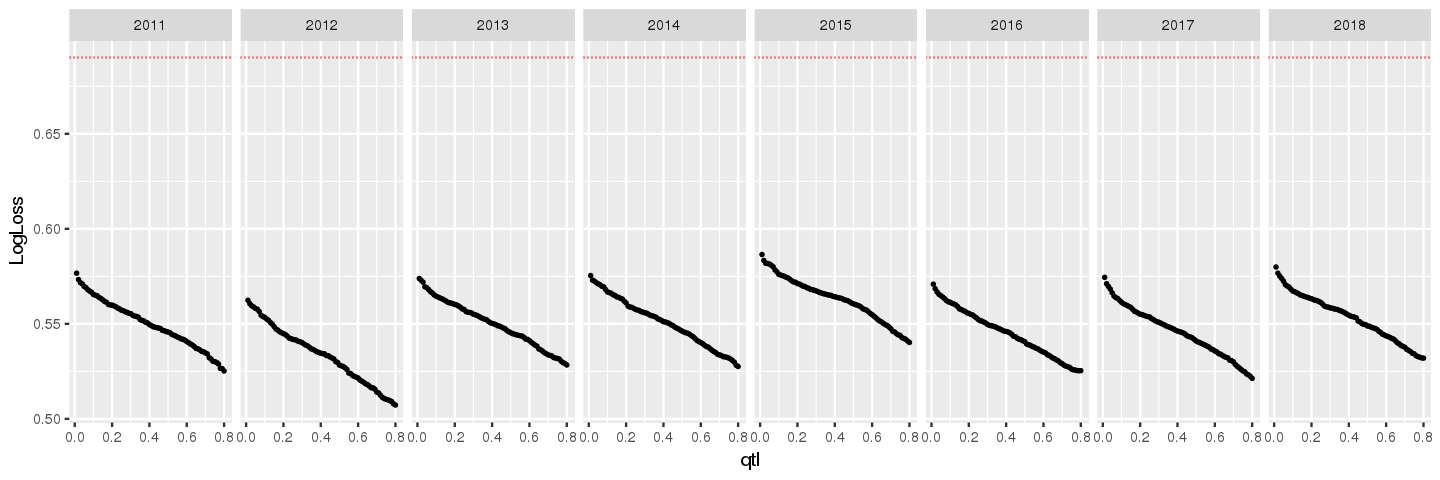

In [25]:
options(repr.plot.width=12, repr.plot.height=4)
ggplot(data=df.train.perf,aes(x=qtl,y=LogLoss)) + 
    geom_point(size=0.5) + 
    geom_hline(yintercept=0.69,color='red',linetype="dotted") +
    facet_grid(. ~ Season)

### Tourney matchups performance (validation dataset)

#### Load test data

In [26]:
data.valid.matchups <- readRDS('../datafiles_rds/TourneyMatchups.rds')
data.valid.matchups %>% filter(Season>2010) -> data.valid.matchups
data.valid.matchups %>% head

data.valid.truth <- readRDS('../datafiles_rds/TourneyTrueResults.rds')
data.valid.truth %>% sample_n(5)

Season,TeamID.x,TeamID.y
2011,1155,1421
2011,1155,1427
2011,1155,1433
2011,1155,1163
2011,1155,1196
2011,1155,1211


ID,Target
2011_1137_1163,0
2011_1345_1433,0
2003_1196_1358,1
2017_1246_1417,1
2014_1272_1438,0


#### prepare

In [27]:
# matchups dataframe : all the possible matches between the 68 teams per Season 
data.valid.matchups %>%
    inner_join(df.ratings,by=c('Season','TeamID.x'='TeamID')) %>%
    select(-Offense,-Defense,-Team) %>%
    inner_join(df.ratings,by=c('Season','TeamID.y'='TeamID')) %>% 
    select(-Offense,-Defense,-Team) -> data.valid.matchups

In [28]:
data.valid.matchups %>% head

Season,TeamID.x,TeamID.y,Rating.x,Rating.y
2011,1155,1421,1816.663,1461.296
2011,1155,1427,1816.663,1372.421
2011,1155,1433,1816.663,1621.168
2011,1155,1163,1816.663,1902.492
2011,1155,1196,1816.663,1868.436
2011,1155,1211,1816.663,1833.901


In [29]:
# all matchs with all 80 hyper parameter setting (qtl=[0.01,0.80]) 
data.valid.matchups %>% 
    inner_join(df.slopes,by=c('Season')) -> df.valid.matchups
df.valid.matchups %>% sample_n(5)

Season,TeamID.x,TeamID.y,Rating.x,Rating.y,qtl,Slope
2015,1211,1434,2004.532,1583.091,0.34,0.003223689
2017,1112,1343,2023.674,1717.798,0.21,0.003492264
2012,1172,1257,1637.068,1877.549,0.79,0.005984738
2014,1113,1372,1899.753,1636.588,0.71,0.005272054
2015,1181,1414,2033.016,1502.415,0.36,0.003246118


In [30]:
# machups predictions : compute the winning probability of TeamID.x and cap it into [0.05,0.95] to avoid too much logloss is case of FP or FN 
df.valid.matchups %>% 
    mutate(ID=str_c(Season,'_',TeamID.x,'_',TeamID.y)) %>% 
    mutate(Prob=logistic(Rating.x-Rating.y,a=Slope)) %>% 
    mutate(Pred=ifelse(Prob>0.5,1,0)) %>% 
    mutate(Prob=round(Prob,3)) %>%
    mutate_which(Prob>0.95,Prob=0.95) %>%
    mutate_which(Prob<0.05,Prob=0.05) %>%
    select(Season,qtl,ID,Pred,Prob) -> df.valid.submit
df.valid.submit %>% sample_n(5)

Season,qtl,ID,Pred,Prob
2013,0.27,2013_1276_1458,1,0.545
2016,0.56,2016_1139_1153,0,0.492
2011,0.34,2011_1114_1421,0,0.455
2011,0.70,2011_1196_1385,1,0.544
2014,0.17,2014_1329_1417,1,0.592


In [32]:
# merge prediction and truth
data.valid.truth %>% inner_join(df.valid.submit,by='ID') -> df.valid.results

In [33]:
# compute accuracy & Logloss per qtl to find the best one per Season
df.valid.results %>% 
    mutate(OK=ifelse(Pred==Target,1,0)) %>%
    mutate(LogLoss=Target*log(Prob) + (1-Target)*log(1-Prob)) %>%
    group_by(Season,qtl) %>%
    summarise(TC=sum(OK),N=n(),FC=N-TC,Acc=TC/N,LogLoss=-mean(LogLoss)) %>%
    select(Season,qtl,TC,FC,N,Acc,LogLoss) -> df.valid.perf
df.valid.perf %>% arrange(LogLoss) %>% group_by(Season) %>% slice(1:1) %>% ungroup() 

Season,qtl,TC,FC,N,Acc,LogLoss
2011,0.03,44,23,67,0.6567164,0.6237015
2012,0.58,46,21,67,0.6865672,0.5607843
2013,0.55,47,20,67,0.7014925,0.5632454
2014,0.46,45,22,67,0.6716418,0.5763720
2015,0.80,49,18,67,0.7313433,0.5082502
2016,0.38,47,20,67,0.7014925,0.5764951
2017,0.75,46,21,67,0.6865672,0.4969401
2018,0.61,43,24,67,0.6417910,0.5880233


In [34]:
df.valid.perf %>% distinct(Season,Acc) %>% spread(Season,Acc,sep='_') %>%
    mutate(Stat='Accuracy') %>% select(Stat,everything()) -> tmp01
df.valid.perf %>% arrange(LogLoss) %>% group_by(Season) %>% slice(1:1) %>% ungroup() %>% 
    select(Season,LogLoss) %>% spread(Season,LogLoss,sep='_') %>% mutate(Stat='Best LogLoss') %>% select(Stat,everything()) -> tmp02
df.valid.perf %>% arrange(LogLoss) %>% group_by(Season) %>% slice(1:1) %>% ungroup() %>% 
    select(Season,qtl) %>% spread(Season,qtl,sep='_') %>% mutate(Stat='Best Quantile') %>% select(Stat,everything()) -> tmp03
tmp01 %>% bind_rows(tmp02) %>% bind_rows(tmp03)

Stat,Season_2011,Season_2012,Season_2013,Season_2014,Season_2015,Season_2016,Season_2017,Season_2018
Accuracy,0.6567164,0.6865672,0.7014925,0.6716418,0.7313433,0.7014925,0.6865672,0.6417910
Best LogLoss,0.6237015,0.5607843,0.5632454,0.5763720,0.5082502,0.5764951,0.4969401,0.5880233
Best Quantile,0.0300000,0.5800000,0.5500000,0.4600000,0.8000000,0.3800000,0.7500000,0.6100000


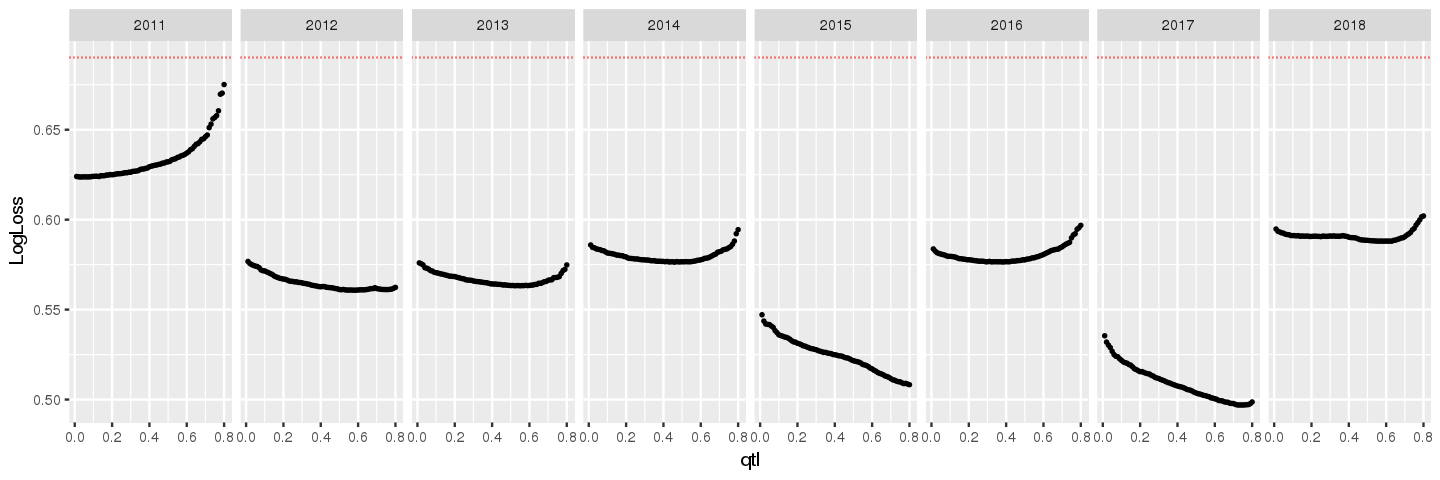

In [35]:
# LogLoss 
options(repr.plot.width=12, repr.plot.height=4)
ggplot(data=df.valid.perf,aes(x=qtl,y=LogLoss)) + 
    geom_point(size=0.5) + 
    geom_hline(yintercept=0.69,color='red',linetype="dotted") +
    facet_grid(. ~ Season)

### Analysis

In [49]:
# compute accuracy & Logloss per qtl to find the best one per Season
df.valid.results %>% 
    mutate(OK=ifelse(Pred==Target,1,0)) %>%
    mutate(LogLoss=Target*log(Prob) + (1-Target)*log(1-Prob)) %>%
    filter(Season==2014,qtl==0.5) %>% 
    select(-qtl,-Season) -> df.valid.details

In [62]:
df.valid.details %>% filter(OK==0) %>% group_by(Target) %>% summarise(m=mean(LogLoss))
df.valid.details %>% filter(OK==1) %>% group_by(Target) %>% summarise(m=mean(LogLoss))

Target,m
0,-1.163517
1,-1.025300


Target,m
0,-0.3310006
1,-0.3470470


In [74]:
df.valid.matchups %>% 
    filter(qtl==0.5,Season==2014) %>%
    select(-qtl) %>%
    mutate(ID=str_c(Season,'_',TeamID.x,'_',TeamID.y)) %>% 
    inner_join(data.valid.truth,by='ID') %>% 
    mutate(Prob=logistic(Rating.x-Rating.y,a=Slope)) %>% 
    mutate(Pred=ifelse(Prob>0.5,1,0)) %>% 
    mutate(Prob=round(Prob,3)) %>%
    mutate_which(Prob>0.95,Prob=0.95) %>%
    mutate_which(Prob<0.05,Prob=0.05) %>% 
    select(-Slope,-Season) %>% 
    select(ID,everything()) %>% 
    filter(Target!=Pred) %>% 
    mutate(delta=Rating.x-Rating.y) %>% head(20)


ID,TeamID.x,TeamID.y,Rating.x,Rating.y,Target,Prob,Pred,delta
2014_1301_1462,1301,1462,1722.681,1858.845,1,0.360,0,-136.16414
2014_1163_1196,1163,1196,1920.875,2063.231,1,0.354,0,-142.35580
2014_1163_1277,1163,1277,1920.875,2038.244,1,0.378,0,-117.36926
2014_1163_1437,1163,1437,1920.875,2037.704,1,0.379,0,-116.82875
2014_1163_1235,1163,1235,1920.875,2034.178,1,0.382,0,-113.30257
2014_1163_1246,1163,1246,1920.875,1990.789,1,0.427,0,-69.91391
2014_1173_1393,1173,1393,1807.130,1976.028,1,0.329,0,-168.89840
2014_1173_1390,1173,1390,1807.130,1857.425,1,0.447,0,-50.29560
2014_1173_1326,1173,1326,1807.130,2074.093,1,0.244,0,-266.96300
2014_1295_1328,1295,1328,1662.324,1873.147,1,0.291,0,-210.82322
